In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

Derive all the math for the multi planet case with up to 5 planets:

In [3]:
import sympy as sm
from math import factorial

N_tot = 5

amn, amx = sm.symbols("amn, amx")

for nmax in range(N_tot+1):
    invam1 = 1
    a_s = [amn]
    p_s = []
    prior = 1
    for n in range(nmax+1):
        if n < nmax:
            a = sm.symbols("a{0}".format(n+1))
            a_s.append(a)
            inva = 1 / a
            prior = prior * inva
        else:
            inva = 0
        p_s.append(invam1 - inva)
        invam1 = inva

    probs = []
    for p in p_s:
        res = factorial(nmax) * p * prior
        for i in range(len(a_s)-1, 0, -1):
            res = sm.integrate(res, (a_s[i], a_s[i-1], amx))
        probs.append(sm.simplify(res))

    print("norm *= log(amx) - log(amn)")
    for i in range(nmax+1):
        print("P_{0}_{1} =".format(nmax, i), probs[i])
        print("P_{0}_{1} /= norm".format(nmax, i))
    print()

norm *= log(amx) - log(amn)
P_0_0 = 1
P_0_0 /= norm

norm *= log(amx) - log(amn)
P_1_0 = -log(amn) + log(amx) + 1/amx - 1/amn
P_1_0 /= norm
P_1_1 = (-amn + amx)/(amn*amx)
P_1_1 /= norm

norm *= log(amx) - log(amn)
P_2_0 = log(amn)**2 - 2*log(amn)*log(amx) + log(amx)**2 - 2/amx + 2*log(amn)/amn - 2*log(amx)/amn + 2/amn
P_2_0 /= norm
P_2_1 = -2*log(amn)/amx + 2*log(amx)/amx + 4/amx - 2*log(amn)/amn + 2*log(amx)/amn - 4/amn
P_2_1 /= norm
P_2_2 = 2*log(amn)/amx - 2*log(amx)/amx - 2/amx + 2/amn
P_2_2 /= norm

norm *= log(amx) - log(amn)
P_3_0 = -log(amn)**3 + 3*log(amn)**2*log(amx) - 3*log(amn)*log(amx)**2 + log(amx)**3 + 6/amx - 3*log(amn)**2/amn + 6*log(amn)*log(amx)/amn - 6*log(amn)/amn - 3*log(amx)**2/amn + 6*log(amx)/amn - 6/amn
P_3_0 /= norm
P_3_1 = 6*log(amn)/amx - 6*log(amx)/amx - 18/amx + 3*log(amn)**2/amn - 6*log(amn)*log(amx)/amn + 12*log(amn)/amn + 3*log(amx)**2/amn - 12*log(amx)/amn + 18/amn
P_3_1 /= norm
P_3_2 = 3*log(amn)**2/amx - 6*log(amn)*log(amx)/amx - 12*log(amn)/amx + 3

In [4]:
fs = [sm.symbols("f{0}".format(i)) for i in range(1, N_tot+1)]
fs = [1 - sum(fs)] + fs
ps = [0 for i in range(N_tot+1)]
for n in range(nmax+1):
    for i in range(n+1):
        P_ = sm.symbols("P_{0}_{1}".format(n, i))
        ps[i] = ps[i] + fs[n] * P_

L = 0
for n in range(nmax+1):
    N = sm.symbols("N{0}".format(n))
    L += N * sm.log(ps[n])
    
print("L =", L)

L = N0*log(P_0_0*(-f1 - f2 - f3 - f4 - f5 + 1) + P_1_0*f1 + P_2_0*f2 + P_3_0*f3 + P_4_0*f4 + P_5_0*f5) + N1*log(P_1_1*f1 + P_2_1*f2 + P_3_1*f3 + P_4_1*f4 + P_5_1*f5) + N2*log(P_2_2*f2 + P_3_2*f3 + P_4_2*f4 + P_5_2*f5) + N3*log(P_3_3*f3 + P_4_3*f4 + P_5_3*f5) + N4*log(P_4_4*f4 + P_5_4*f5) + N5*log(P_5_5*f5)


Download some Kepler data:

In [5]:
import os
import requests
import pandas as pd
from io import BytesIO

def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

In [6]:
import numpy as np

stlr = get_catalog("q1_q17_dr25_stellar")

# Select G and K dwarfs.
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 100.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 23490 targets after cuts


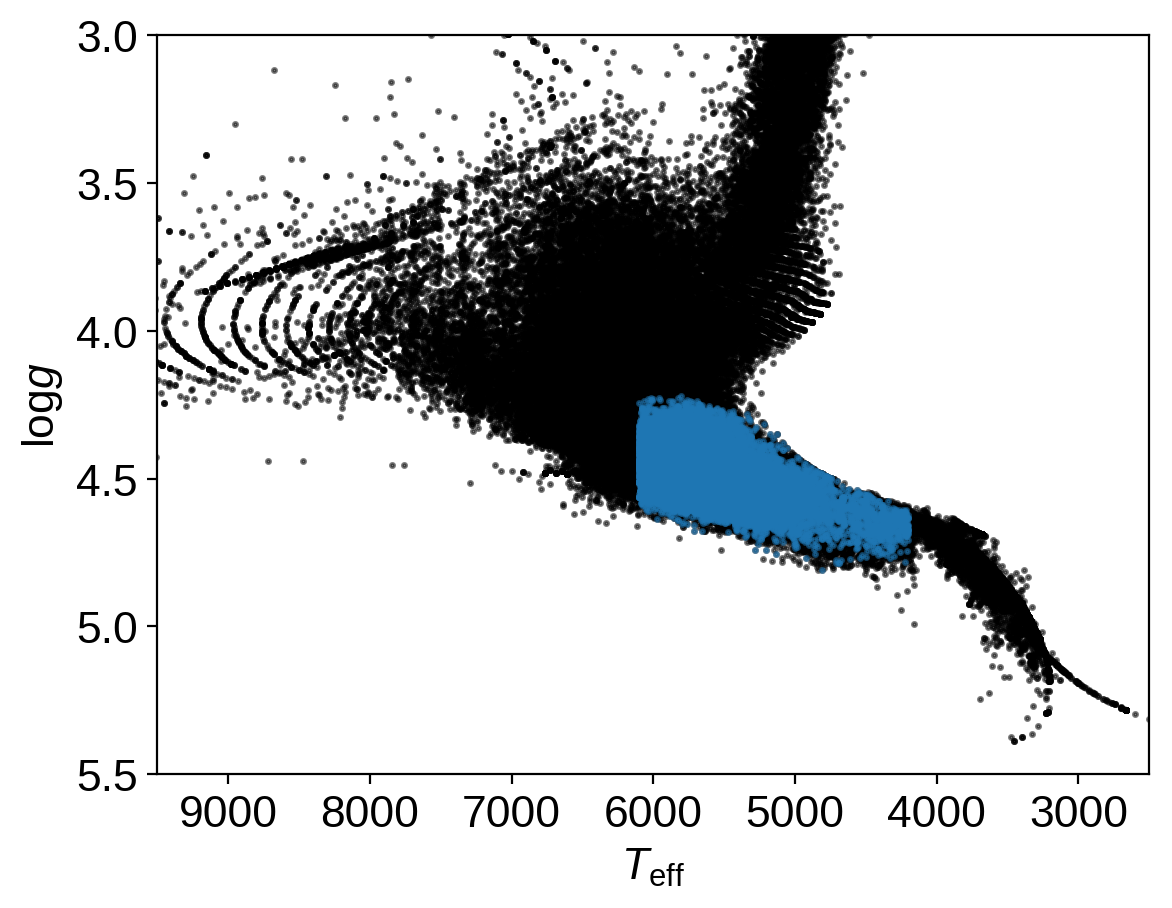

In [7]:
import matplotlib.pyplot as plt

plt.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5, rasterized=True)
plt.plot(stlr.teff, stlr.logg, ".", ms=3, alpha=0.5, rasterized=True)
plt.xlim(9500, 2500)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");

In [51]:
kois = get_catalog("q1_q17_dr25_koi")

a_rng = (10, 30)
r_rng = (0.5, 8.0)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (a_rng[0] <= kois.koi_dor) & (kois.koi_dor <= a_rng[1])
m &= np.isfinite(kois.koi_prad) & (r_rng[0] <= kois.koi_prad) & (kois.koi_prad <= r_rng[1])

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 367 KOIs after cuts


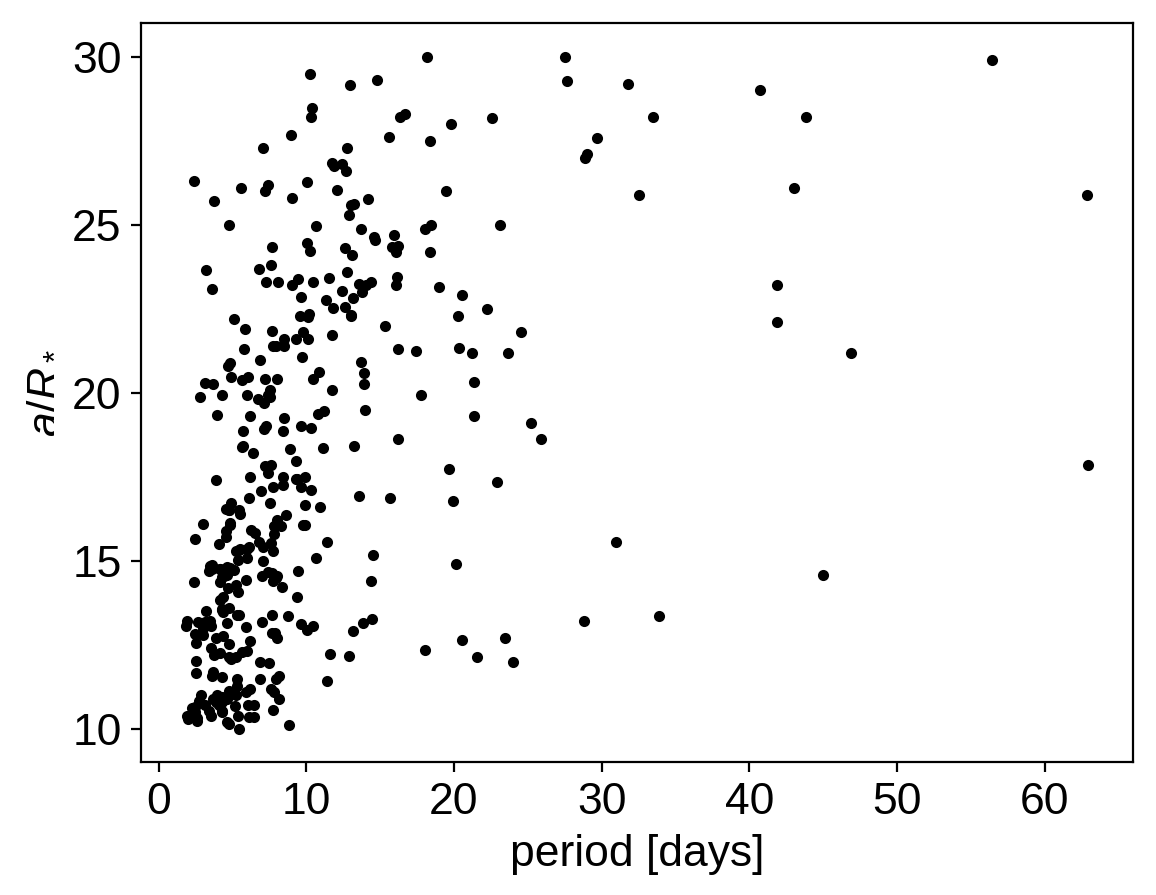

In [52]:
plt.plot(kois.koi_period, kois.koi_dor, ".k")
plt.xlabel("period [days]")
plt.ylabel("$a / R_*$");

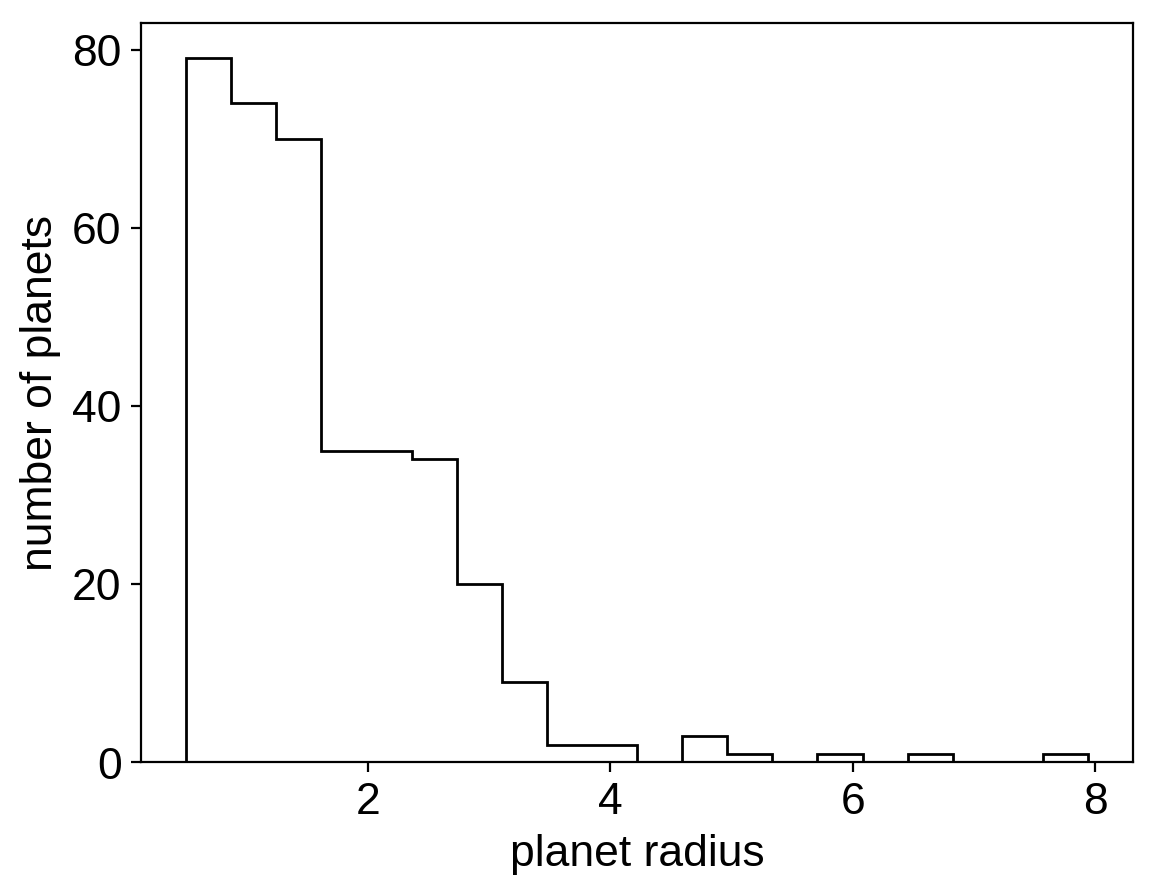

In [53]:
plt.hist(kois.koi_prad, 20, histtype="step", color="k")
plt.xlabel("planet radius")
plt.ylabel("number of planets");

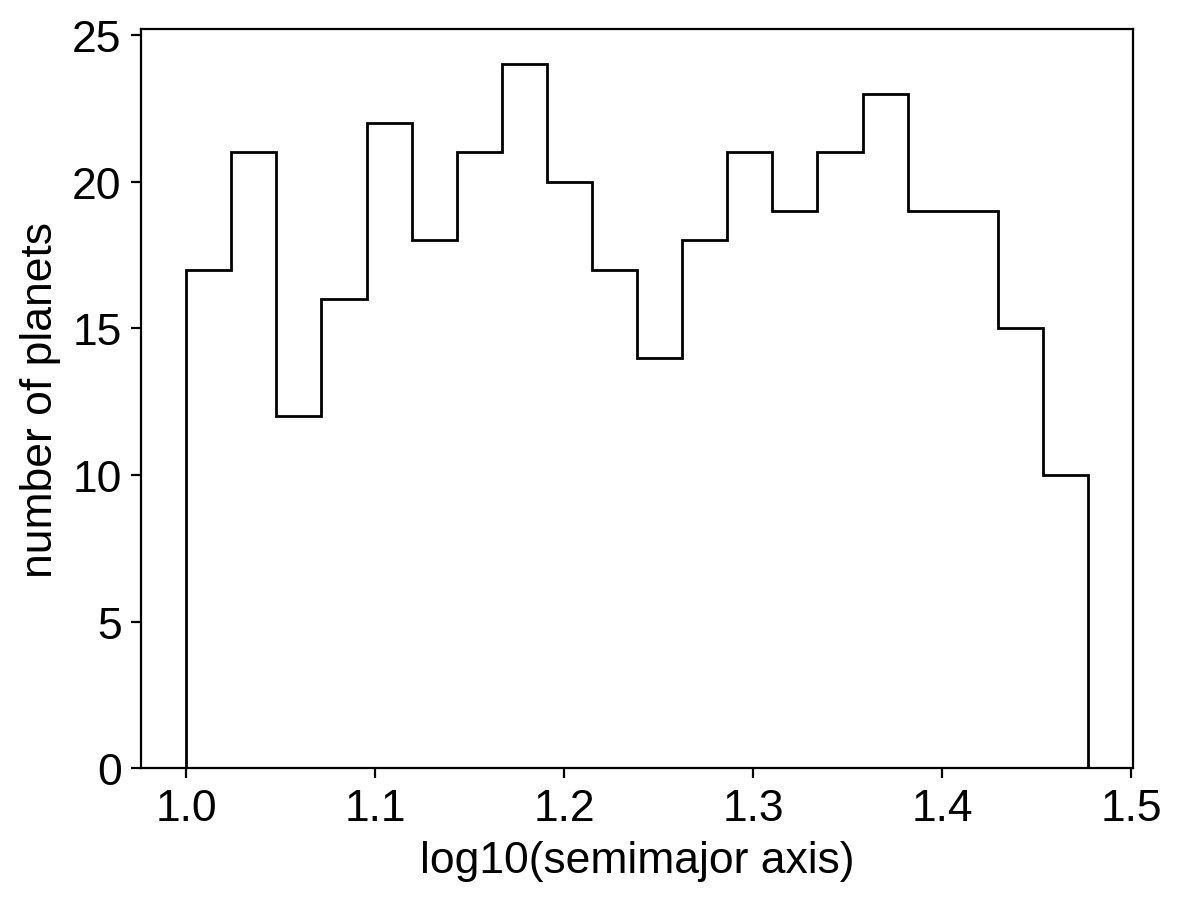

In [54]:
plt.hist(np.log10(kois.koi_dor), 20, histtype="step", color="k")
plt.xlabel("log10(semimajor axis)")
plt.ylabel("number of planets");

Compute the observed multiplicity distribution:

In [55]:
data = kois.groupby("kepid").count().groupby("kepoi_name").count().kepler_name
obs_hist = np.zeros(6)
obs_hist[1:1+len(data)] = np.array(data)
obs_hist[0] = len(stlr) - np.sum(obs_hist)
N0, N1, N2, N3, N4, N5 = obs_hist

In [56]:
obs_hist

array([2.3205e+04, 2.2300e+02, 4.8000e+01, 9.0000e+00, 4.0000e+00,
       1.0000e+00])

Sample the model using PyMC3:

In [57]:
import pymc3 as pm
import exoplanet as xo

amn, amx = a_rng
log = np.log

norm = 1
P_0_0 = 1
P_0_0 /= norm

norm *= log(amx) - log(amn)
P_1_0 = -log(amn) + log(amx) + 1/amx - 1/amn
P_1_0 /= norm
P_1_1 = (-amn + amx)/(amn*amx)
P_1_1 /= norm

norm *= log(amx) - log(amn)
P_2_0 = log(amn)**2 - 2*log(amn)*log(amx) + log(amx)**2 - 2/amx + 2*log(amn)/amn - 2*log(amx)/amn + 2/amn
P_2_0 /= norm
P_2_1 = -2*log(amn)/amx + 2*log(amx)/amx + 4/amx - 2*log(amn)/amn + 2*log(amx)/amn - 4/amn
P_2_1 /= norm
P_2_2 = 2*log(amn)/amx - 2*log(amx)/amx - 2/amx + 2/amn
P_2_2 /= norm

norm *= log(amx) - log(amn)
P_3_0 = -log(amn)**3 + 3*log(amn)**2*log(amx) - 3*log(amn)*log(amx)**2 + log(amx)**3 + 6/amx - 3*log(amn)**2/amn + 6*log(amn)*log(amx)/amn - 6*log(amn)/amn - 3*log(amx)**2/amn + 6*log(amx)/amn - 6/amn
P_3_0 /= norm
P_3_1 = 6*log(amn)/amx - 6*log(amx)/amx - 18/amx + 3*log(amn)**2/amn - 6*log(amn)*log(amx)/amn + 12*log(amn)/amn + 3*log(amx)**2/amn - 12*log(amx)/amn + 18/amn
P_3_1 /= norm
P_3_2 = 3*log(amn)**2/amx - 6*log(amn)*log(amx)/amx - 12*log(amn)/amx + 3*log(amx)**2/amx + 12*log(amx)/amx + 18/amx - 6*log(amn)/amn + 6*log(amx)/amn - 18/amn
P_3_2 /= norm
P_3_3 = 3*(2*amn*(log(amx) + 1)*log(amn) + amn*(-2*(log(amx) + 1)*log(amx) - log(amn)**2 + log(amx)**2 - 2) + 2*amx)/(amn*amx)
P_3_3 /= norm

norm *= log(amx) - log(amn)
P_4_0 = log(amn)**4 - 4*log(amn)**3*log(amx) + 6*log(amn)**2*log(amx)**2 - 4*log(amn)*log(amx)**3 + log(amx)**4 - 24/amx + 4*log(amn)**3/amn - 12*log(amn)**2*log(amx)/amn + 12*log(amn)**2/amn + 12*log(amn)*log(amx)**2/amn - 24*log(amn)*log(amx)/amn + 24*log(amn)/amn - 4*log(amx)**3/amn + 12*log(amx)**2/amn - 24*log(amx)/amn + 24/amn
P_4_0 /= norm
P_4_1 = -24*log(amn)/amx + 24*log(amx)/amx + 96/amx - 4*log(amn)**3/amn + 12*log(amn)**2*log(amx)/amn - 24*log(amn)**2/amn - 12*log(amn)*log(amx)**2/amn + 48*log(amn)*log(amx)/amn - 72*log(amn)/amn + 4*log(amx)**3/amn - 24*log(amx)**2/amn + 72*log(amx)/amn - 96/amn
P_4_1 /= norm
P_4_2 = -12*log(amn)**2/amx + 24*log(amn)*log(amx)/amx + 72*log(amn)/amx - 12*log(amx)**2/amx - 72*log(amx)/amx - 144/amx + 12*log(amn)**2/amn - 24*log(amn)*log(amx)/amn + 72*log(amn)/amn + 12*log(amx)**2/amn - 72*log(amx)/amn + 144/amn
P_4_2 /= norm
P_4_3 = -4*log(amn)**3/amx + 12*log(amn)**2*log(amx)/amx + 24*log(amn)**2/amx - 12*log(amn)*log(amx)**2/amx - 48*log(amn)*log(amx)/amx - 72*log(amn)/amx + 4*log(amx)**3/amx + 24*log(amx)**2/amx + 72*log(amx)/amx + 96/amx - 24*log(amn)/amn + 24*log(amx)/amn - 96/amn
P_4_3 /= norm
P_4_4 = 4*(3*amn*(log(amx)**2 + 2*log(amx) + 2)*log(amn) + amn*(-3*(log(amx) + 1)*log(amn)**2 + 3*(log(amx) + 1)*log(amx)**2 - 3*(log(amx)**2 + 2*log(amx) + 2)*log(amx) + log(amn)**3 - log(amx)**3 - 6) + 6*amx)/(amn*amx)
P_4_4 /= norm

norm *= log(amx) - log(amn)
P_5_0 = -log(amn)**5 + 5*log(amn)**4*log(amx) - 10*log(amn)**3*log(amx)**2 + 10*log(amn)**2*log(amx)**3 - 5*log(amn)*log(amx)**4 + log(amx)**5 + 120/amx - 5*log(amn)**4/amn + 20*log(amn)**3*log(amx)/amn - 20*log(amn)**3/amn - 30*log(amn)**2*log(amx)**2/amn + 60*log(amn)**2*log(amx)/amn - 60*log(amn)**2/amn + 20*log(amn)*log(amx)**3/amn - 60*log(amn)*log(amx)**2/amn + 120*log(amn)*log(amx)/amn - 120*log(amn)/amn - 5*log(amx)**4/amn + 20*log(amx)**3/amn - 60*log(amx)**2/amn + 120*log(amx)/amn - 120/amn
P_5_0 /= norm
P_5_1 = 120*log(amn)/amx - 120*log(amx)/amx - 600/amx + 5*log(amn)**4/amn - 20*log(amn)**3*log(amx)/amn + 40*log(amn)**3/amn + 30*log(amn)**2*log(amx)**2/amn - 120*log(amn)**2*log(amx)/amn + 180*log(amn)**2/amn - 20*log(amn)*log(amx)**3/amn + 120*log(amn)*log(amx)**2/amn - 360*log(amn)*log(amx)/amn + 480*log(amn)/amn + 5*log(amx)**4/amn - 40*log(amx)**3/amn + 180*log(amx)**2/amn - 480*log(amx)/amn + 600/amn
P_5_1 /= norm
P_5_2 = 60*log(amn)**2/amx - 120*log(amn)*log(amx)/amx - 480*log(amn)/amx + 60*log(amx)**2/amx + 480*log(amx)/amx + 1200/amx - 20*log(amn)**3/amn + 60*log(amn)**2*log(amx)/amn - 180*log(amn)**2/amn - 60*log(amn)*log(amx)**2/amn + 360*log(amn)*log(amx)/amn - 720*log(amn)/amn + 20*log(amx)**3/amn - 180*log(amx)**2/amn + 720*log(amx)/amn - 1200/amn
P_5_2 /= norm
P_5_3 = 20*log(amn)**3/amx - 60*log(amn)**2*log(amx)/amx - 180*log(amn)**2/amx + 60*log(amn)*log(amx)**2/amx + 360*log(amn)*log(amx)/amx + 720*log(amn)/amx - 20*log(amx)**3/amx - 180*log(amx)**2/amx - 720*log(amx)/amx - 1200/amx + 60*log(amn)**2/amn - 120*log(amn)*log(amx)/amn + 480*log(amn)/amn + 60*log(amx)**2/amn - 480*log(amx)/amn + 1200/amn
P_5_3 /= norm
P_5_4 = 5*log(amn)**4/amx - 20*log(amn)**3*log(amx)/amx - 40*log(amn)**3/amx + 30*log(amn)**2*log(amx)**2/amx + 120*log(amn)**2*log(amx)/amx + 180*log(amn)**2/amx - 20*log(amn)*log(amx)**3/amx - 120*log(amn)*log(amx)**2/amx - 360*log(amn)*log(amx)/amx - 480*log(amn)/amx + 5*log(amx)**4/amx + 40*log(amx)**3/amx + 180*log(amx)**2/amx + 480*log(amx)/amx + 600/amx - 120*log(amn)/amn + 120*log(amx)/amn - 600/amn
P_5_4 /= norm
P_5_5 = 5*(4*amn*(log(amx)**3 + 3*log(amx)**2 + 6*log(amx) + 6)*log(amn) + amn*(4*(log(amx) + 1)*log(amn)**3 - 4*(log(amx) + 1)*log(amx)**3 - 6*(log(amx)**2 + 2*log(amx) + 2)*log(amn)**2 + 6*(log(amx)**2 + 2*log(amx) + 2)*log(amx)**2 - 4*(log(amx)**3 + 3*log(amx)**2 + 6*log(amx) + 6)*log(amx) - log(amn)**4 + log(amx)**4 - 24) + 24*amx)/(amn*amx)
P_5_5 /= norm


sampler = xo.PyMC3Sampler()
with pm.Model() as model:
    
    f1 = pm.Uniform("f1", lower=0, upper=1)
    f2 = pm.Uniform("f2", lower=0, upper=1)
    f3 = pm.Uniform("f3", lower=0, upper=1)
    f4 = pm.Uniform("f4", lower=0, upper=1)
    f5 = pm.Uniform("f5", lower=0, upper=1)
    
    log = pm.math.log
    L = N0*log(P_0_0*(-f1 - f2 - f3 - f4 - f5 + 1) + P_1_0*f1 + P_2_0*f2 + P_3_0*f3 + P_4_0*f4 + P_5_0*f5) + N1*log(P_1_1*f1 + P_2_1*f2 + P_3_1*f3 + P_4_1*f4 + P_5_1*f5) + N2*log(P_2_2*f2 + P_3_2*f3 + P_4_2*f4 + P_5_2*f5) + N3*log(P_3_3*f3 + P_4_3*f4 + P_5_3*f5) + N4*log(P_4_4*f4 + P_5_4*f5) + N5*log(P_5_5*f5)

    pm.Potential("loglike", L)
    
    sampler.tune(tune=5000, target_accept=0.9)
    trace = sampler.sample(draws=5000)

Sampling 2 chains: 100%|██████████| 104/104 [00:00<00:00, 844.92draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f5, f4, f3, f2, f1]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1450.64draws/s]


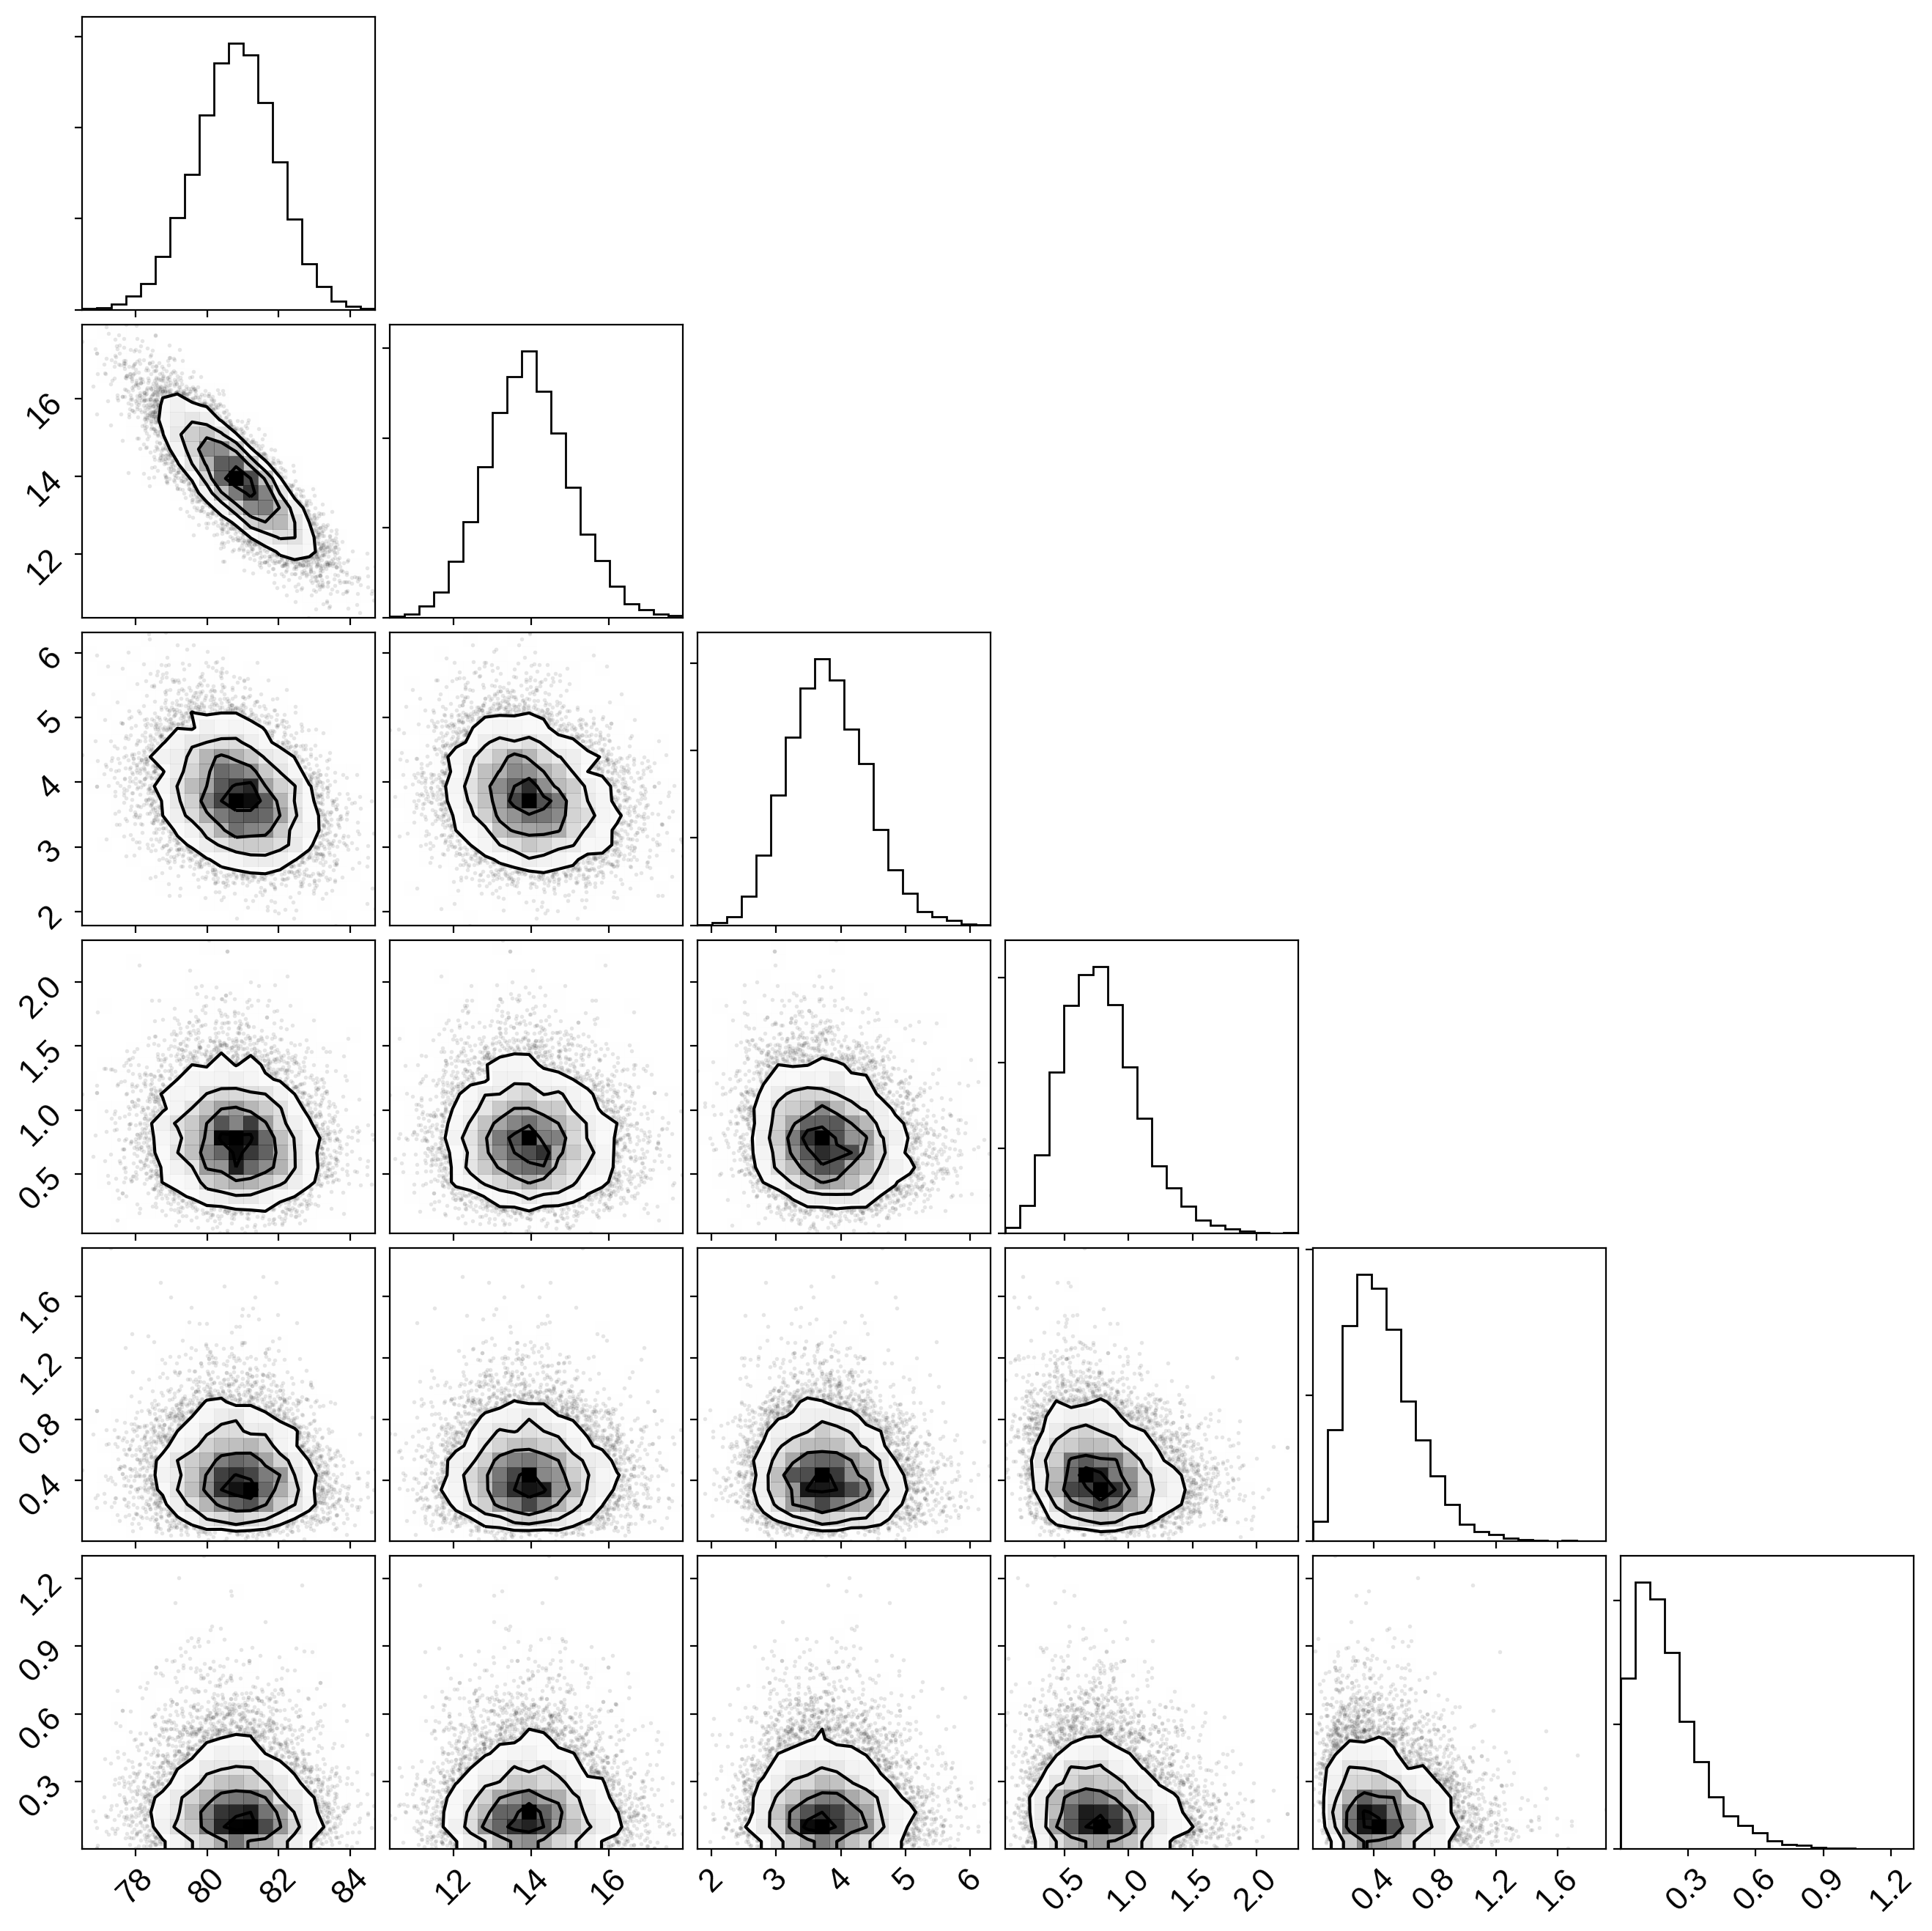

In [58]:
import corner
samples = np.array(pm.trace_to_dataframe(trace))
zero = 1.0 - np.sum(samples, axis=1)
samples = np.concatenate((zero[:, None], samples), axis=1)
corner.corner(100*samples);

In [59]:
Np = np.sum(obs_hist[1:])
f = Np / (P_1_1 * len(stlr))
sig2 = f**2 * (1-f*P_1_1)**2 / (N0 * P_1_1**2 * f**2 + Np*(1-f*P_1_1)**2)
sig = np.sqrt(sig2)

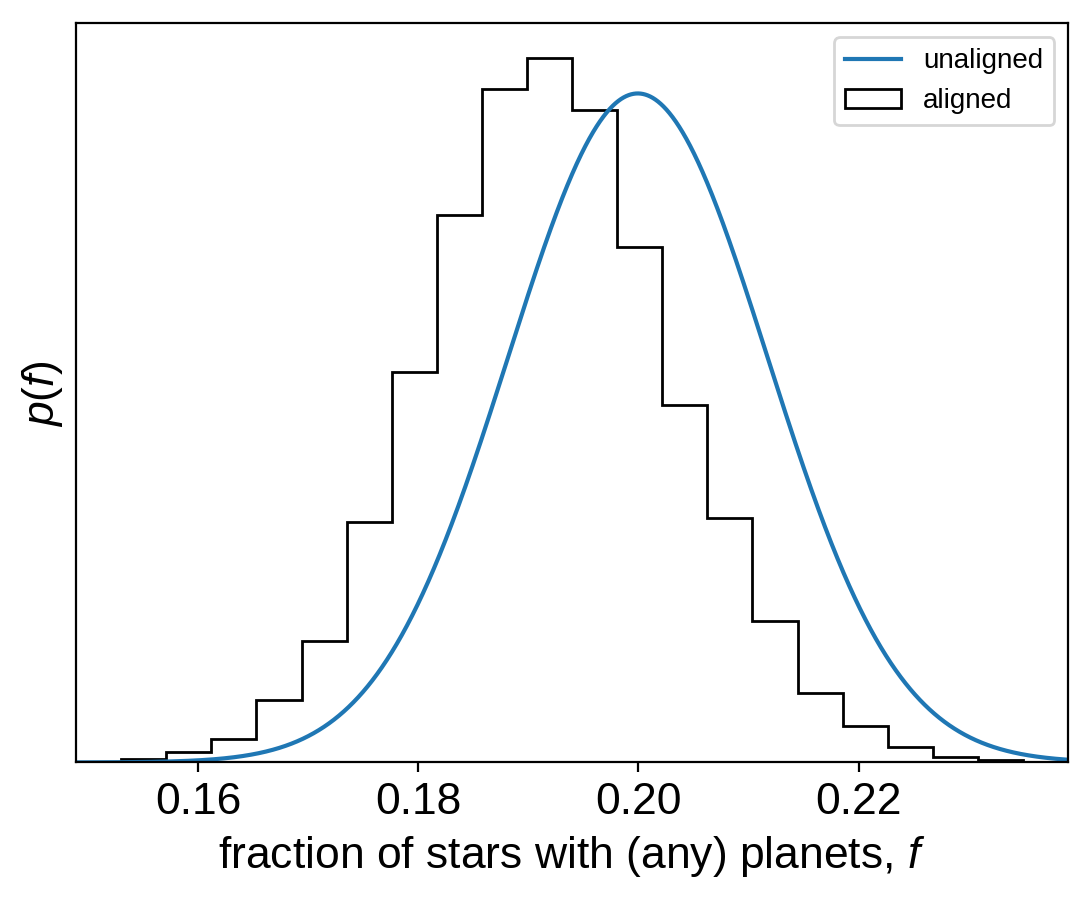

In [78]:
_, bins, _ = plt.hist(np.sum(samples[:, 1:], axis=1), 20, color="k", histtype="step",
                      density=True, label="aligned")
xlim = plt.xlim()
fval = np.linspace(*xlim, 5000)
plt.plot(fval, np.exp(-0.5*(fval - f)**2 / sig2)/np.sqrt(2*np.pi*sig2),
         label="unaligned")
plt.xlabel("fraction of stars with (any) planets, $f$")
plt.ylabel("$p(f)$")
plt.yticks([])
plt.legend(fontsize=10)
plt.xlim(xlim)
plt.savefig("kepler1.pdf", bbox_inches="tight");

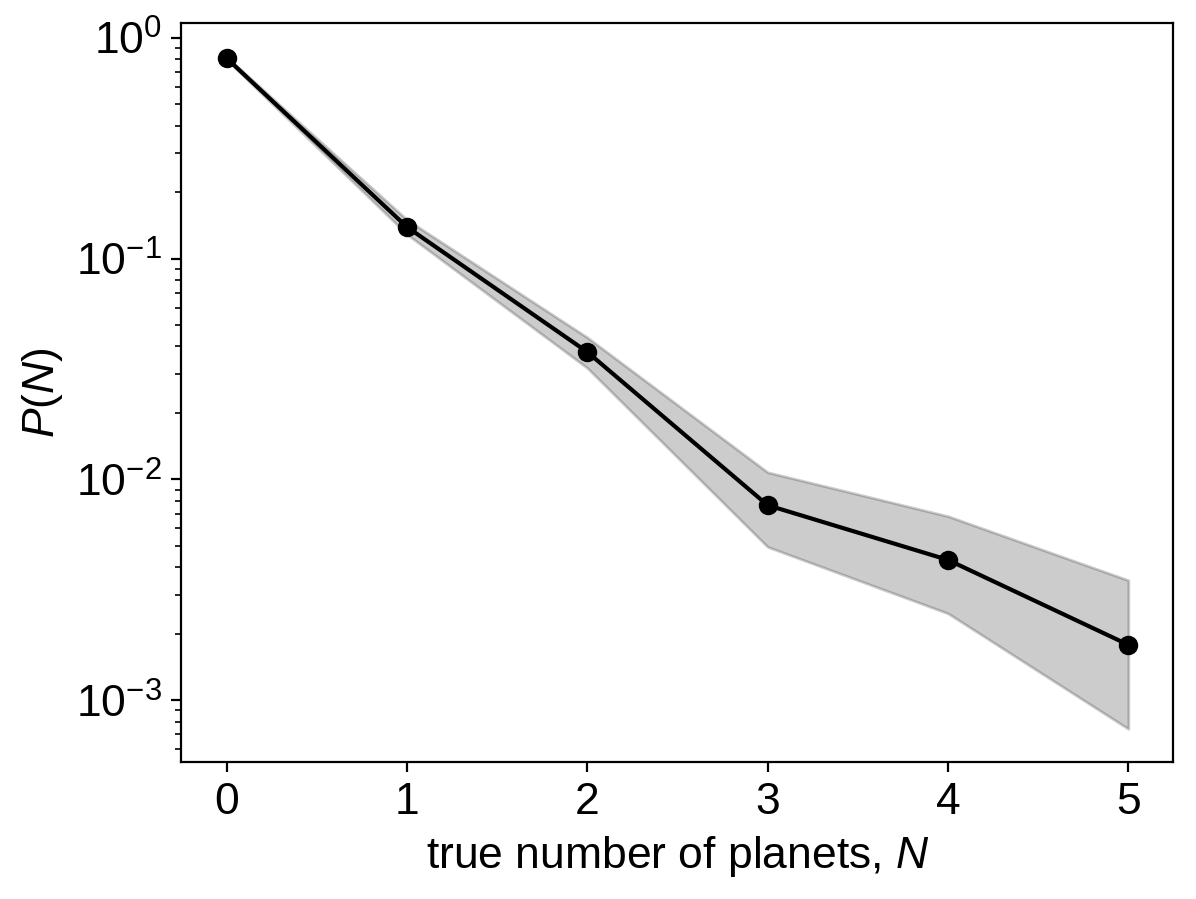

In [68]:
x = np.arange(samples.shape[1])
q = np.percentile(samples, [16, 50, 84], axis=0)
plt.semilogy(x, q[1], "o-k")
plt.fill_between(x, q[0], q[2], color="k", alpha=0.2)
plt.xlabel("true number of planets, $N$")
plt.ylabel("$P(N)$")
plt.savefig("kepler2.pdf", bbox_inches="tight");

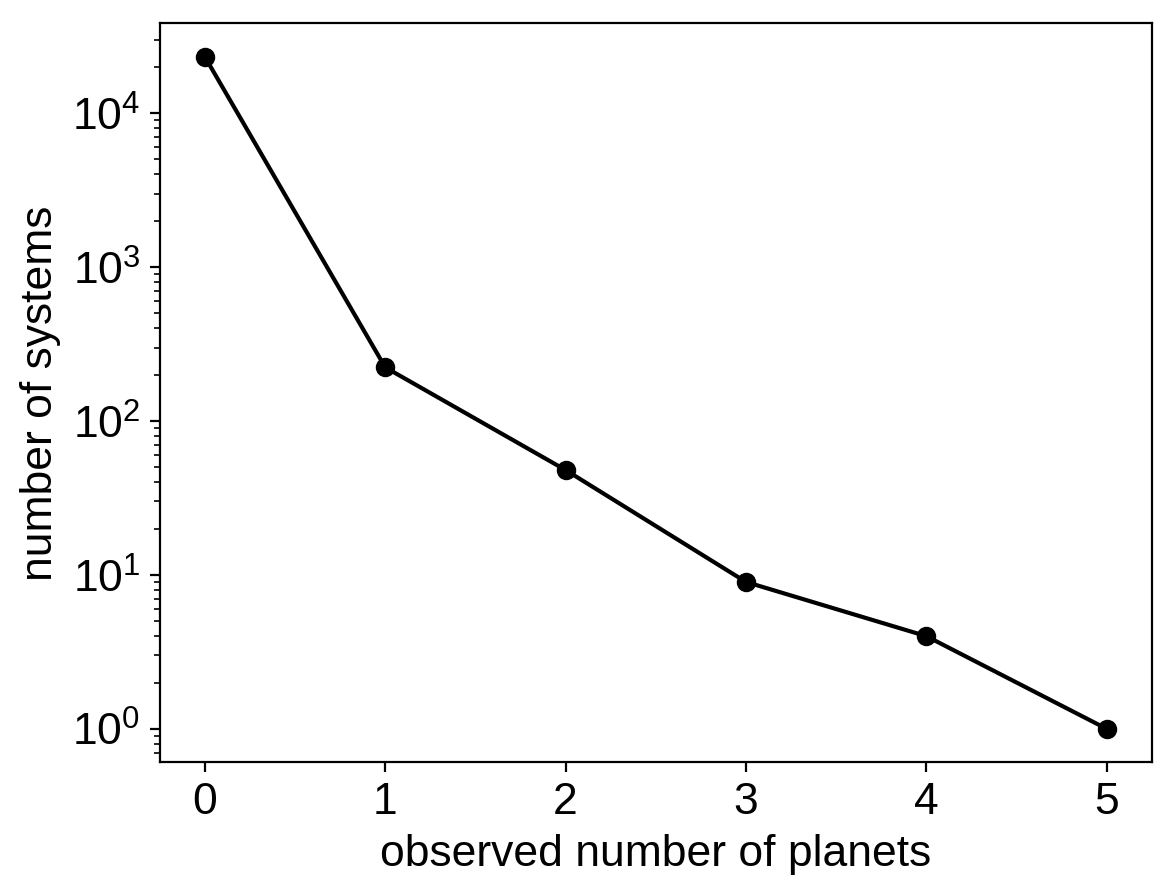

In [77]:
plt.semilogy(x, obs_hist, "o-k")
plt.xlabel("observed number of planets")
plt.ylabel("number of systems")
plt.savefig("kepler3.pdf", bbox_inches="tight");